# Фильтр Кэнни 

**Шаги детектора:**

- Убрать шум и лишние детали из изображения
- Рассчитать градиент изображения
- Сделать края тонкими (edge thinning)
- Связать края в контура (edge linking)

In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import math

Зададим функцию для рисования картинок сразу в тетради Jupyter Notebook

In [2]:
def draw_borders(img):
    """
    Функция для отрисовки исходной картинки и границ иглы при помощи фильтра Кэнни
    
    img - исходная картинка
    """
    canny = cv.Canny(img, 100, 200)
    plt.figure(figsize=(13, 13))
    plt.subplot(121), plt.imshow(img, cmap='gray')
    plt.title('Черно-белая картинка')
    plt.subplot(122), plt.imshow(canny, cmap='gray')
    plt.title('Границы алмазной иглы')
    plt.show()

### Пример 1

Алмазная игла, где кончик иглы четко разлечим
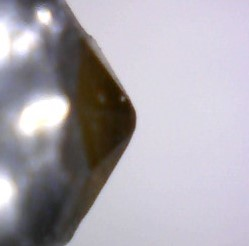

In [3]:
img_1 = cv.imread('..//dataset/zoom_needle/b_needle_1.jpg', cv.IMREAD_GRAYSCALE)

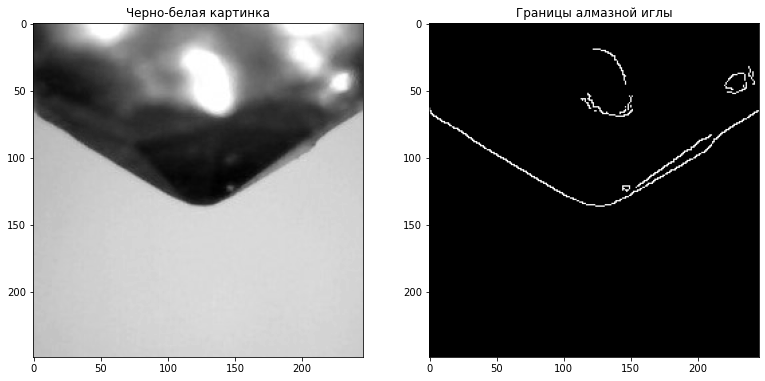

In [4]:
draw_borders(img_1)

### Пример 2

На фоне имеются другие объекты, цвет кончика иглы и фон находятся в одной цветовой гамме

<img src="../dataset/zoom_needle/b_needle_2.jpg" alt="затупленная игла с невыраженными границами" width="200"/>

In [5]:
img_2 = cv.imread('..//dataset/zoom_needle/b_needle_2.jpg', cv.IMREAD_GRAYSCALE)

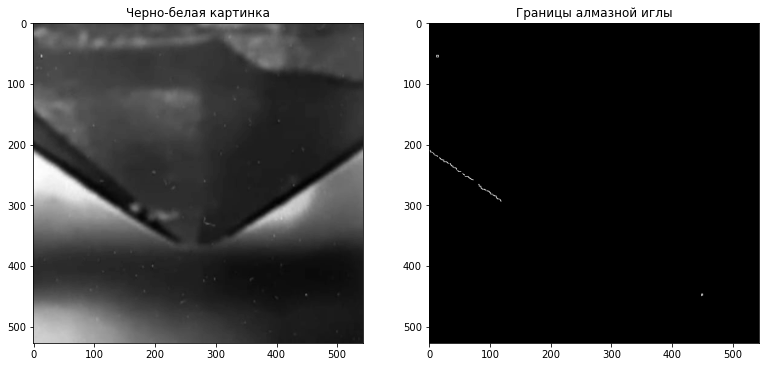

In [6]:
draw_borders(img_2)

#### Повышение контрастности ЧБ изображения
Попробуем улучшить результат работы фильтра, изменяя контрастность черно-белой картинки

In [7]:
def calc_gray_hist(img):
    """
    Функция для расчёта гистограммы распределения серого на картинке
    
    img - исходная картинка
    """
    height, weight = img.shape[:2]
    grayHist = np.zeros([256], np.uint64)
    for i in range(height):
        for j in range(weight):
            grayHist[img[i][j]] += 1
    return grayHist

In [8]:
def gray_hist(img):
    """
    Функция для отрисовки гистограммы распределения серого на картинке
    
    img - исходная картинка
    """
    height, weight = img.shape[:2]
    pixelSequence = img.reshape([height * weight, ])
    numberBins = 256
    histogram, bins, patch = plt.hist(pixelSequence, numberBins,
                                      facecolor='black', histtype='bar')
    plt.xlabel("gray label")
    plt.ylabel("number of pixels")
    plt.axis([0, 255, 0, np.max(histogram)])
    plt.show()

**1. Cпособ улучшения картинки**

***Нормализация гистограммы***

которая представляет собой метод линейного преобразования, который автоматически выбирает значения a и b, где

$a = \frac{O_{max}-O_{min}}{I_{max}-I_{min}},b=O_{min}-\frac{O_{max}-O_{min}}{I_{max}-I_{min}}*I_{min}$,

где 
- $O_{max},O_{min}$ - минимальный уровень серого и максимальный уровень серого, отображаемые в исходном изображении
- $I_{max},I_{min}$- минимальный уровень серого и максимальный уровень серого, заданный самостоятельно

*Замечание:*

Если $a > 1$, коэффициент контрастности выходного изображения увеличивается, если $0 < a < 1$, коэффициент контрастности уменьшается маленький. 

Изменение значения $b$ влияет на яркость выходного изображения. При $b > 0$ яркость увеличивается, а при $b < 0$ яркость уменьшается.

In [9]:
def normaliz_hist(img):
    """
    Функция для нормализации гистограммы распределения серого на картинке
    
    img - исходная картинка
    """
    i_min, i_max = cv.minMaxLoc(img)[:2]
    o_min, o_max = 0, 255
    
     # Рассчитать значения a и b
    a = float(o_max - o_min) / (i_max - i_min)
    b = o_min - a * i_min
    
    out = a * img + b
    out = out.astype(np.uint8)
    return out

In [10]:
img_2_normaliz = normaliz_hist(img_2)

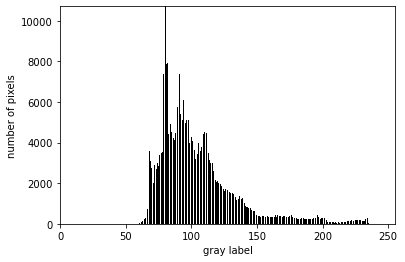

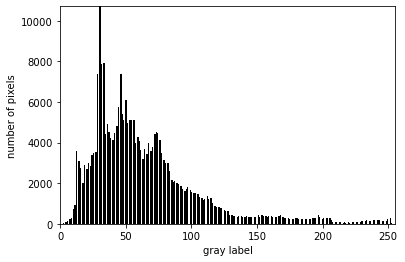

In [11]:
gray_hist(img_2)
gray_hist(img_2_normaliz)

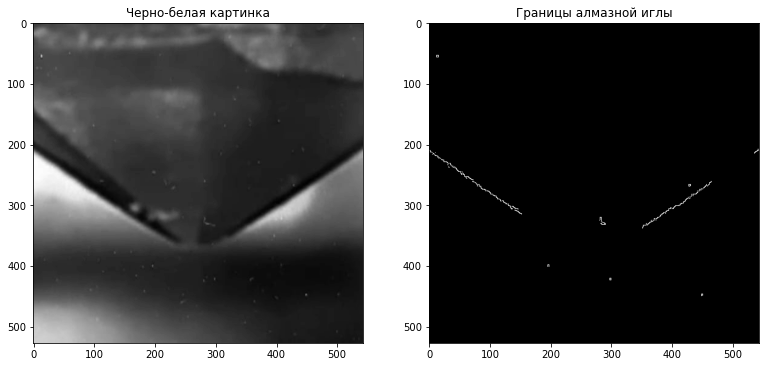

In [12]:
draw_borders(img_2_normaliz)

**2. Cпособ улучшения картинки**

***Глобальное выравнивание гистограммы***

Реализация выравнивания гистограммы в основном делится на четыре этапа:
1. Рассчитайте гистограмму градаций серого изображения
2. Рассчитать кумулятивную гистограмму серой гистограммы
3. Соотношение между уровнем серого на входе и уровнем серого на выходе
4. Циклически выводить уровень серого каждого пикселя изображения в соответствии с соотношением отображения

Соотношение сопоставления:

$q=\frac{\sum_{k=0}^{p}hist_{I}(k)}{H*W}*256-1$

Где q - выходной пиксель, а p - входной пиксель. 

Можно так понять, $\frac{\sum_{k=0}^{p}hist_{I}(k)}{H*W}$

Этот термин эквивалентен гистограмме совокупной вероятности гистограммы градаций серого (в диапазоне от 0 до 1), а затем увеличивает диапазон до 0–255, чтобы получить пиксели выходного изображения.

In [13]:
def equal_hist(img):
    """
    Функция для глобального выравнивания гистограммы распределения серого на картинке
    
    img - исходная картинка
    """
    # Высота и ширина матрицы серого изображения
    height, weight = img.shape
         # Шаг 1: Рассчитать гистограмму в градациях серого
    gray_hist = calc_gray_hist(img)
         # Шаг 2: Рассчитать накопленную серую гистограмму
    zero_cumu_moment = np.zeros([256], np.uint32)
    for p in range(256):
        if p == 0:
            zero_cumu_moment[p] = gray_hist[0]
        else:
            zero_cumu_moment[p] = zero_cumu_moment[p - 1] + gray_hist[p]
         # Шаг 3: Получить соотношение отображения между уровнем серого на входе и уровнем серого на основе накопленной гистограммы серого
    out_put_q = np.zeros([256], np.uint8)
    cofficient = 256.0 / (height * weight)
    for p in range(256):
        q = cofficient * float(zero_cumu_moment[p]) - 1
        if q >= 0:
            out_put_q[p] = math.floor(q)
        else:
            out_put_q[p] = 0
         # Четвертый шаг: получить выровненное изображение гистограммы
    equal_hist_image = np.zeros(img.shape, np.uint8)
    for i in range(height):
        for j in range(weight):
            equal_hist_image[i][j] = out_put_q[img[i][j]]
    return equal_hist_image

In [14]:
img_2_equal = equal_hist(img_2)

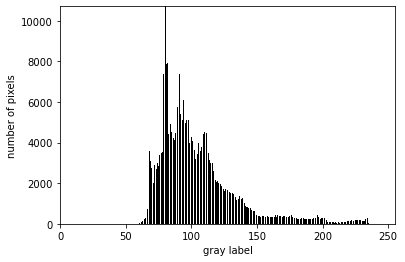

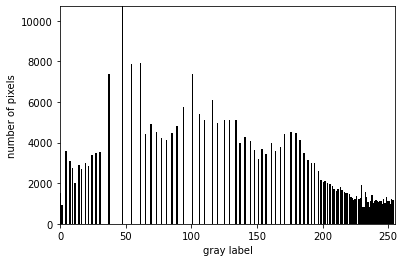

In [15]:
gray_hist(img_2)
gray_hist(img_2_equal)

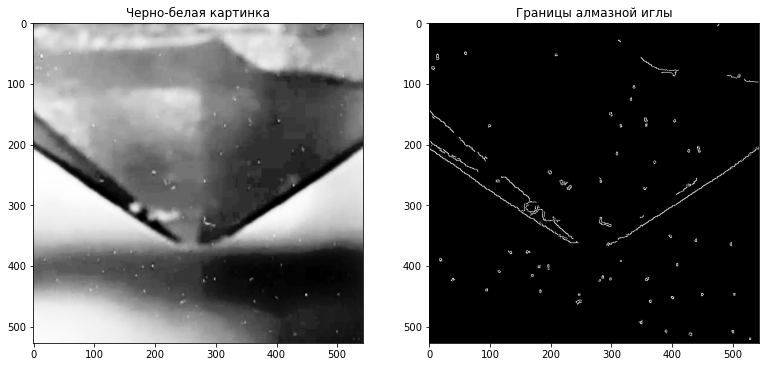

In [16]:
draw_borders(img_2_equal)

**3. Cпособ улучшения картинки**

***Адаптивная коррекция гистограммы с ограниченным контрастом***

Адаптивное выравнивание гистограммы сначала делит изображение на непересекающиеся региональные блоки, а затем выполняет выравнивание гистограммы для каждого блока отдельно. Очевидно, что при отсутствии шума гистограмма в градациях серого для каждой небольшой области будет ограничена небольшим диапазоном градаций серого, но при наличии шума после выполнения выравнивания гистограммы для каждого блока разделенной области, Шум будет усиливаться. 

Во избежание появления шума предлагается «Ограничение контраста» (Contrast Limiting). Если интервал гистограммы заранее превышает предварительно установленный «предел контраста», он будет обрезан, а затем обрезанная часть будет равномерно распределена между другими Бин, тем самым восстанавливая гистограмму. Далее вводится функция выравнивания адаптивной гистограммы для ограничения контраста, реализованная OpenCV,

In [17]:
def additive_correct(img):
    """
    Функция для адаптивной коррекции гистограммы распределения серого на картинке
    
    img - исходная картинка
    """
    new_img = cv.resize(img, None, fx=0.5, fy=0.5)
     # Создать объект CLAHE
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    
     # Адаптивное пороговое выравнивание для ограничения контраста
    dst = clahe.apply(img)
    return dst

In [18]:
img_2_dst = additive_correct(img_2)

Адаптивное пороговое выравнивание для ограничения контраста

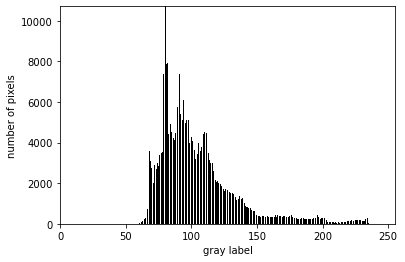

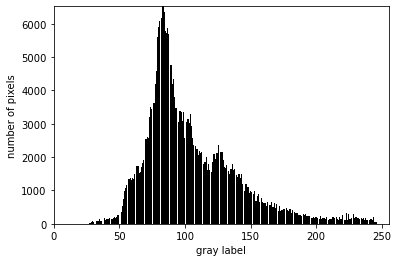

In [19]:
gray_hist(img_2)
gray_hist(img_2_dst)

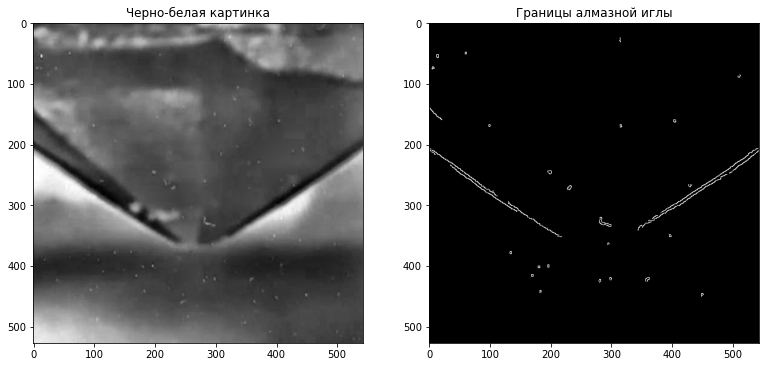

In [20]:
draw_borders(img_2_dst)

***Выполним два преобразования гистограммы - это aдаптивное пороговое выравнивание для ограничения контраста и глобальное выравнивание гистограммы***

In [21]:
img_2_equal_dst = equal_hist(img_2_dst)

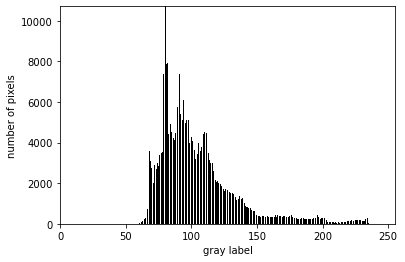

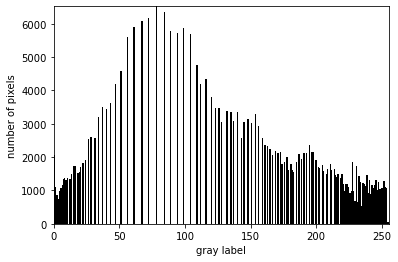

In [22]:
gray_hist(img_2)
gray_hist(img_2_equal_dst)

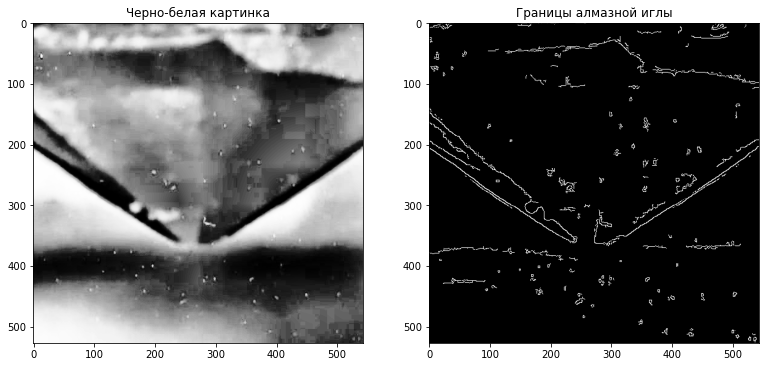

In [23]:
draw_borders(img_2_equal_dst)

## Пример 3

Кончик иглы на картинке просматривается плохо, а так же есть некоторые искревления в основании самой иглы

<img src="../dataset/zoom_needle/b_needle_7.jpg" alt="затупленная игла с невыраженными границами с обточенными краями" width="200"/>

**1. Построение границ алмазной иглы без преобразований изображения**

In [24]:
img_3 = cv.imread('..//dataset/zoom_needle/b_needle_7.jpg', cv.IMREAD_GRAYSCALE)

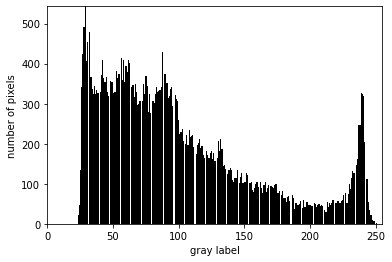

In [25]:
gray_hist(img_3)

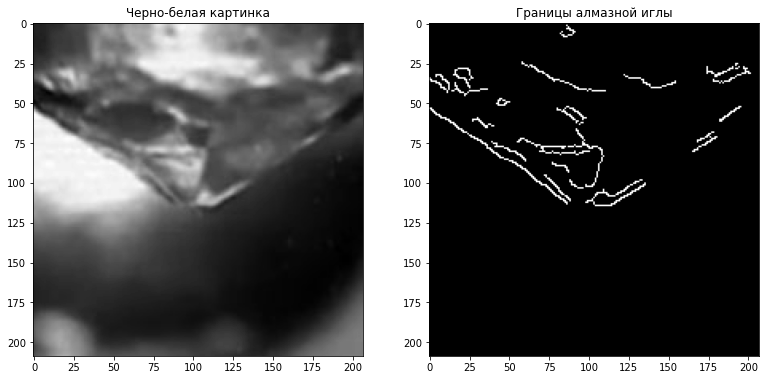

In [26]:
draw_borders(img_3)

*Попробуем улучшить результат, уже известными способами из примера 2*

***Нормализация гистограммы***

In [27]:
img_3_normaliz = normaliz_hist(img_3)

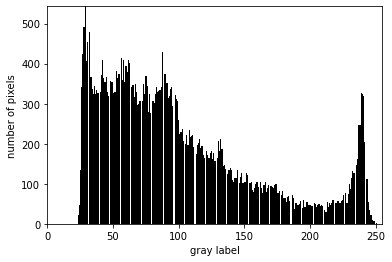

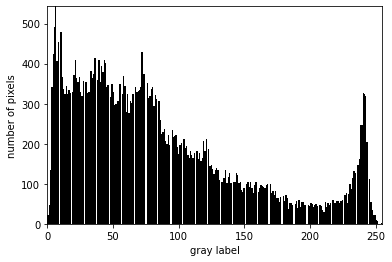

In [28]:
gray_hist(img_3)
gray_hist(img_3_normaliz)

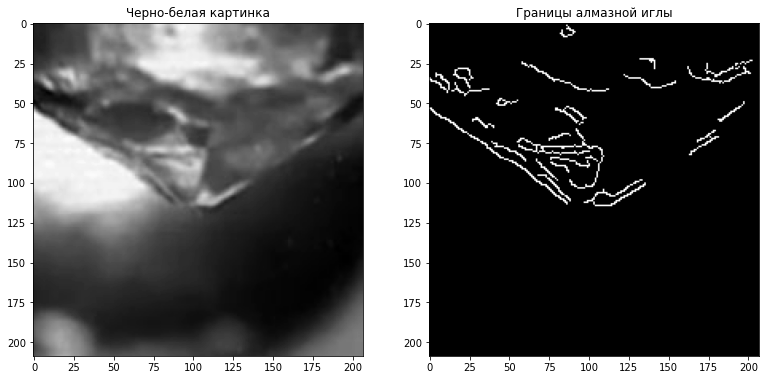

In [30]:
draw_borders(img_3_normaliz)

***Глобальное выравнивание гистограммы***

In [31]:
img_3_equal = equal_hist(img_3_normaliz)

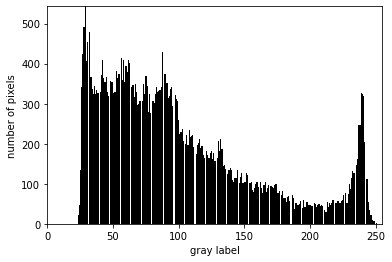

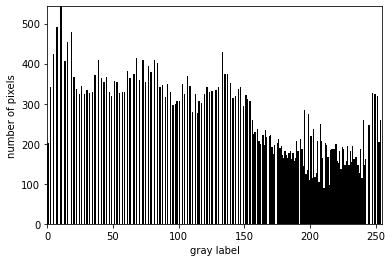

In [32]:
gray_hist(img_3)
gray_hist(img_3_equal)

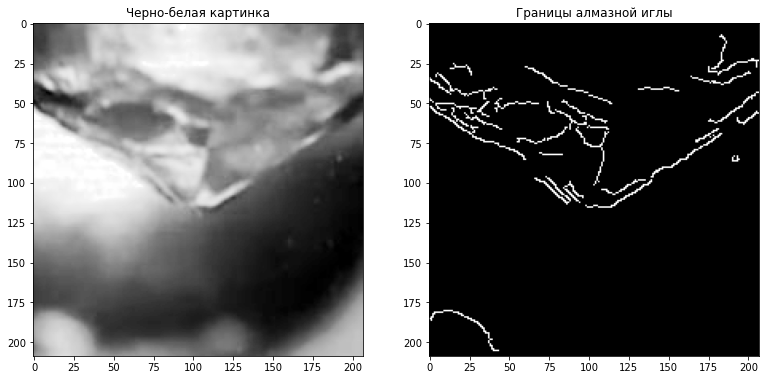

In [33]:
draw_borders(img_3_equal)

***Адаптивная коррекция гистограммы с ограниченным контрастом***

In [34]:
img_3_dst = additive_correct(img_3)

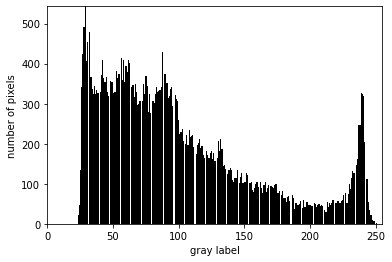

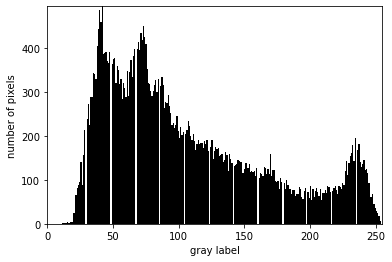

In [35]:
gray_hist(img_3)
gray_hist(img_3_dst)

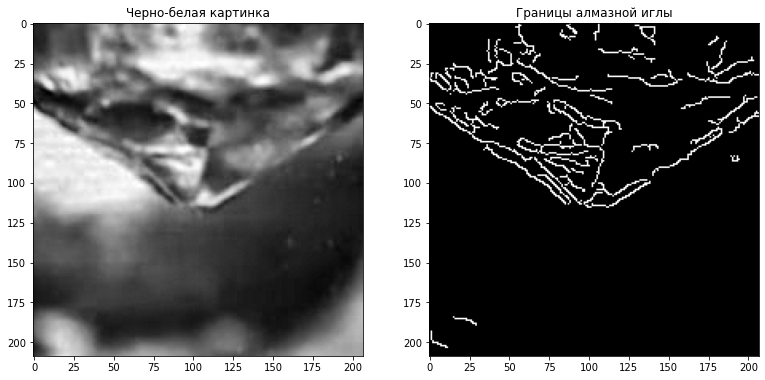

In [36]:
draw_borders(img_3_dst)

**Вывод:** Таким образом можно заметить, что на картинках, где есть какие-то помехи на фоне или же есть рельефы на самой алмазной игле, трудно определить границы с помощью выбранного алгоритма 

Источники : 
- [OpenCV - улучшения изображения](https://russianblogs.com/article/3280416547/)
- [Обработка изображения — детектор границ Кенни (Canny)](https://robocraft.ru/blog/computervision/484.html)
- [Поиск объектов через определение их контуров средствами OpenCV](https://vc.ru/dev/286152-poisk-obektov-cherez-opredelenie-ih-konturov-sredstvami-opencv)